In [3]:
from pathlib import Path
import gzip
import pickle
import matplotlib.pyplot as plt
import torch
from torch import tensor
import numpy as np

np.set_printoptions(precision=2, linewidth=140)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

MNIST_URL = "https://github.com/MrHeadbang/machineLearning/raw/main/mnist.zip"
path_data = Path("data")
path_data.mkdir(exist_ok=True)
path_zip = path_data / "mnist.zip"

if not path_zip.exists(): 
    from urllib.request import urlretrieve
    urlretrieve(MNIST_URL, path_zip)

with gzip.open(path_zip) as f: 
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = pickle.load(f, encoding="latin-1")
    x_train, y_train, x_val, y_val, x_test, y_test = map(tensor, (x_train, y_train, x_val, y_val, x_test, y_test))


In [5]:
n, m = x_train.shape
c = y_train.max() + 1
n, m, c

(50000, 784, tensor(10))

In [7]:
nh = 50

w1 = torch.randn(m, nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)
b2 = torch.zeros(1)

In [8]:
def lin(x, w, b): return x@w + b

In [15]:
t = lin(x_train, w1, b1)
print(t.shape)
t[0, :5]

torch.Size([50000, 50])


tensor([  2.40,   5.29,  -9.52,  11.67, -11.20])

In [10]:
def relu(x): return x.clamp_min(0.)

In [14]:
t = relu(t)
t[0, :5]

tensor([ 2.40,  5.29,  0.00, 11.67,  0.00])

In [16]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l1 = relu(l1)
    l2 = lin(l1, w2, b2)
    return l2

In [18]:
res = model(x_train)
print(res.shape)
res[:5]

torch.Size([50000, 1])


tensor([[  8.88],
        [-58.29],
        [ -8.12],
        [-33.32],
        [ -1.84]])

In [21]:
res.shape, y_train.shape

(torch.Size([50000, 1]), torch.Size([50000]))

In [23]:
res.squeeze().shape

torch.Size([50000])

In [24]:
def mse(preds, y): return ((preds.squeeze() - y)**2).mean()

In [25]:
mse(res, y_train)

tensor(1495.67)

In [26]:
sum(0.1*x for x in range(10))

4.500000000000001

In [28]:
mse(tensor(4.5), y_train)

tensor(8.36)

In [39]:
print(y_train[:5])
print(tensor(4.5) - y_train[:5])
print((tensor(4.5) - y_train[:5])**2)
print(((tensor(4.5) - y_train[:5])**2).mean())

tensor([5, 0, 4, 1, 9])
tensor([-0.50,  4.50,  0.50,  3.50, -4.50])
tensor([ 0.25, 20.25,  0.25, 12.25, 20.25])
tensor(10.65)


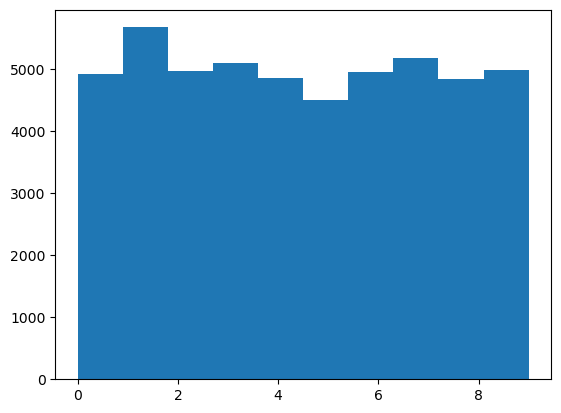

In [46]:
plt.hist(y_train.float(), 10);

In [48]:
from sympy import symbols, diff
x, y = symbols("x, y")

In [52]:
diff(x**2, x), diff(3*x**2 + 9, x), diff((x**3+1)*y, y)

(2*x, 6*x, x**3 + 1)

In [63]:
def lingrad(inp, out, w, b):
    inp.g = out.g @ w.T
    w.g = inp.T @ out.g
    b.g = out.g.sum(0)

In [90]:
def forward_and_backward(inp, targ):
    l1 = lin(inp, w1, b1)
    l2 = relu(l1)
    out = lin(l2, w2, b2)
    diff = out.squeeze() - targ
    loss = (diff**2).mean()

    loss.g = 1.0
    diff.g = loss.g * (2.0*diff/diff.nelement()).unsqueeze(-1)
    out.g = diff.g * 1.0
    lingrad(l2, out, w2, b2)
    l1.g = l2.g * (l1 > 0.0)
    lingrad(inp, l1, w1, b1)

In [91]:
forward_and_backward(x_train, y_train)

In [92]:
def get_grad(x): return x.g.clone()
chks = w1, w2, b1, b2, x_train
grads = w1g, w2g, b1g, b2g, ig = tuple(map(get_grad, chks))

In [93]:
def mkgrad(x): return x.clone().requires_grad_(True)
ptgrads = pw1, pw2, pb1, pb2, px = tuple(map(mkgrad, chks))

In [94]:
def forward(inp, targ):
    l1 = lin(inp, pw1, pb1)
    l1 = relu(l1)
    l2 = lin(l1, pw2, pb2)
    return mse(l2, targ)

In [95]:
loss = forward(px, y_train)
loss.backward()

In [99]:
from fastcore.test import test_close
for i, a, b in zip(range(len(grads)), grads, ptgrads): 
    test_close(a, b.grad, 0.01)

In [103]:
class Relu:
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.0)
        return self.out
    
    def backward(self): 
        self.inp.g = (self.inp > 0.0) * self.out.g

class Lin:
    def __init__(self, w, b):
        self.w = w
        self.b = b
    
    def __call__(self, inp):
        self.inp = inp
        self.out = lin(inp, self.w, self.b)
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.T
        self.w.g = self.inp.T @ self.out.g
        self.b.g = self.out.g.sum(0)

class MSE:
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = mse(inp, targ)

    def backward(self):
        self.inp.g = 2.0 * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

class Model:
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = MSE()

    def __call__(self, x, targ):
        for l in self.layers:
            x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers):
            l.backward()

In [105]:
model = Model(w1, b1, w2, b2)
loss = model(x_train, y_train)
model.backward()

In [106]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

In [107]:
class Module:
    def __call__(self, inp, *args):
        self.inp = inp
        self.args = args
        self.out = self.forward()
        return self.out

    def forward(self): assert False
    def backward(self): assert False

class Lin(Module):
    def __init__(self, w, b):
        self.w = w
        self.b = b

    def forward(self):
        return self.inp@self.w + self.b
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.T
        self.w.g = self.inp.T @ self.out.g
        self.b.g = self.out.g.sum(0)

class Relu(Module):
    def forward(self): 
        return self.inp.clamp_min(0.)
    
    def backward(self): 
        self.inp.g = self.out.g * (self.inp > 0.0)

class Mse(Module):
    def forward (self):
        targ = self.args[0]
        return ((self.inp.squeeze() - targ)**2).mean()
    
    def backward(self): 
        targ = self.args[0]
        self.inp.g = 2.0 * (self.inp.squeeze() - targ).unsqueeze(-1) / targ.shape[0]

In [109]:
model = Model(w1, b1, w2, b2)
loss = model(x_train, y_train)
model.backward()

In [110]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

In [111]:
from torch import nn
import torch.nn.functional as F

In [113]:
class Linear(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.w = torch.randn(n_in, n_out).requires_grad_()
        self.b = torch.zeros(n_out).requires_grad_()

    def forward(self, inp): 
        return inp@self.w + self.b
    
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [Linear(n_in, nh), nn.ReLU(), Linear(nh, n_out)]
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return F.mse_loss(x, targ.unsqueeze(-1))

In [115]:
model = Model(m, nh, 1)
loss = model(x_train.float(), y_train.float())
loss.backward()

In [116]:
l0 = model.layers[0]
l0.b.grad

tensor([ -9.97, -30.55, -20.10,  26.93,   1.61, -58.65,  52.14,   1.65,  32.30, -14.58,  -2.72,  14.98, -29.37,  17.35, -30.62,  70.68,
          2.19, -15.31,   1.41,  70.35,  19.27,  28.08,   6.54, -38.02, -11.55,   5.50,  10.73,  96.44,  18.86,  -5.75,  37.09,  43.77,
         35.34, -74.47,  90.89, -59.05,  49.98,   2.19,  37.49,  28.30,  -2.21, -13.69,  40.10,   4.89,  26.56, -13.67,   1.69,  35.08,
        -50.73, -26.81])